# Analyser

## Kode

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import SpectralBiclustering

In [2]:
def plot_target_histogram(df: pd.DataFrame, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))
    sns.countplot(df['Churned'], ax=ax)
    ax.set_xticklabels(['Kunde', 'Forladt'])
    ax.set_ylabel('Antal')
    ax.set_xlabel('')
    n_non_churned = len(df[df['Churned'] == 0])
    n_churned = len(df[df['Churned'] == 1])
    # ax.set_ylim([0, max(n_non_churned, n_churned) + 20])

    customer_counts = np.array(df.groupby('Churned')['UserId'].count())
    total_count = customer_counts.sum()
    customer_pct = (customer_counts / total_count) * 100

    for i in range(len(customer_pct)):
        p = ax.patches[i]
        percentage = '{:.2f}%'.format(customer_pct[i])
        x = p.get_x()
        y = np.nan_to_num(p.get_y() + p.get_height())
        ax.annotate(percentage, (x, y), fontsize=12)
    return ax
        
def get_annotation_data(df: pd.DataFrame, feature_name: str):
    customer_counts_per_products = list(df[df['Churned'] == 0].groupby(feature_name)['UserId'].count())
    if feature_name == 'NumOfProducts':
        customer_counts_per_products += [0]
    noncustomer_counts_per_products = list(df[df['Churned'] == 1].groupby(feature_name)['UserId'].count())
    customer_counts = np.array(customer_counts_per_products)
    noncustomer_counts = np.array(noncustomer_counts_per_products)
    total_counts = customer_counts + noncustomer_counts
    customer_pct = customer_counts / total_counts
    noncustomer_pct = noncustomer_counts / total_counts
    return np.append(customer_pct, noncustomer_pct)

def plot_histogram(df: pd.DataFrame, feature_name: str, ax=None, annotate: bool = True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    sns.countplot(x=feature_name, hue='Churned', data=df, ax=ax)

    if annotate:
        annotation_data = get_annotation_data(df, feature_name)
        for i in range(len(annotation_data)):
            p = ax.patches[i]
            percentage = '{:.0f}%'.format(100 * annotation_data[i])
            x = p.get_x()
            y = np.nan_to_num(p.get_y() + p.get_height())
            ax.annotate(percentage, (x, y), fontsize=12)  

def plot_index_vs_value(df: pd.DataFrame, feature_name: str, target_name: str = None):
    """Visualisation for determining repeated values.
    Horisontal line segments indicate repeated values.
    Vertical line segments indicate data is not properly shuffled.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    if target_name is None:
        ax.plot(df[feature_name], '.')
    else:
        x = range(len(df[feature_name]))
        y = df[feature_name]
        ax.scatter(x=list(x), y=list(y), c=df[target_name], s=3, cmap='cool', alpha=0.5)
    ax.set_ylabel(feature_name)
    ax.set_xlabel('Index')
    
def plot_dual_histogram(df: pd.DataFrame, feature_name: str, bins=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 5))
    df_unchurned = df[df['Churned'] == 0][feature_name]
    df_churned = df[df['Churned'] == 1][feature_name]
    ax.hist(df_unchurned, label='Kunde', alpha=0.5, bins=bins, color=plot_colors[0])
    ax.hist(df_churned, label='Forladt', alpha=0.5, bins=bins, color=plot_colors[1])
    ax.set_xlabel(feature_name)
    ax.legend()
    
def get_counts(df: pd.DataFrame, feature_name: str, style_format: str = '{:,.1f}'):
    df_counts = pd.DataFrame(df[feature_name].value_counts())
    # df_counts['Proportion'] = df_counts[feature_name].apply(lambda x: '{:.1f} %'.format(x / df_counts[feature_name].sum() * 100))
    df_counts['Proportion'] = df_counts[feature_name].apply(lambda x: x / df_counts[feature_name].sum() * 100)
    return df_counts.T.style.format(style_format)

def plot_corr(df: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(12, 12))
    sns.heatmap(
        df.corr(), 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True,
        ax=ax
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );
    
def plot_important_features_repeated(df: pd.DataFrame, repeat: int = 10, include_random_field: bool = False):
    
    def get_feature_importance():
        X = df.select_dtypes(include=['int64', 'uint8', 'float64']).copy()
        y = X['Churned']
        X.drop('Churned', axis=1, inplace=True)
        if include_random_field:
            X['RandomUniform'] = np.random.random(len(X))
            X['RandomNormal'] = np.random.random(size=len(X))
            X['RandomInt'] = np.random.randint(low=2, high=100, size=len(df))
            X['RandomBool'] = np.random.randint(low=0, high=2, size=len(df))

        # Split datasæt
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

        # Træn en random forest model
        rfc_model = RandomForestClassifier(random_state=42).fit(X_train, y_train)
        return pd.DataFrame({'feature': list(X_train.columns), 'value': list(rfc_model.feature_importances_) })
    
    # Generere data
    df_plot_data = None
    for i in range(repeat):
        df_feat_data = get_feature_importance()
        if df_plot_data is None:
            df_plot_data = df_feat_data
        else:
            df_plot_data = df_plot_data.append(df_feat_data)
    
    # Plot data
    fig, ax = plt.subplots(figsize=(12, 5))
    plot_labels = list(df_plot_data['feature'])
    color_palatte = [
        'red' if 'Random' in plot_labels[i] else plot_colors[4]
        for i in range(df_plot_data.shape[0])
    ]
    df_sorted = df_plot_data.groupby(["feature"])['value'].aggregate(np.mean).reset_index().sort_values('value', ascending=False)

    sns.barplot(x='feature', y='value', order=df_sorted['feature'], data=df_plot_data, ax=ax, palette=color_palatte, capsize=.2)
    ax.set_xticks(plot_x);
    ax.set_xticklabels(plot_labels, rotation=45, horizontalalignment='right');
    ax.set_xlabel('Feature')
    ax.set_ylabel('Vigtighedsscore')
    return df_plot_data

def plot_random_forest_feature_importance(X: pd.DataFrame, y: pd.DataFrame):
    # Træn en random forest model
    rfc_model = RandomForestClassifier(random_state=42).fit(X, y)

    # Plot vigtige features
    df_plot_data = pd.DataFrame({'feature': list(X.columns), 'value': list(rfc_model.feature_importances_) })
    df_plot_data = df_plot_data.sort_values('value', ascending=False)
    fig, ax = plt.subplots(figsize=(12, 5))
    plot_x = list(range(df_plot_data.shape[0]))
    plot_y = list(df_plot_data['value'])
    plot_labels = list(df_plot_data['feature'])
    color_palatte = [
        'red' if 'Random' in plot_labels[i] else plot_colors[4]
        for i in range(df_plot_data.shape[0])
    ]
    sns.barplot(plot_x, plot_y, ax=ax, palette=color_palatte)
    ax.set_xticks(plot_x);
    ax.set_xticklabels(plot_labels, rotation=45, horizontalalignment='right');
    ax.set_ylabel('Feature Importance');
    
def plot_biclustering(df: pd.DataFrame):
    corr_columns = list(df.corr().columns)
    df_corr_data = np.array(df.corr())

    # Slet variancen for at skabe bedre clusters
    I = np.eye(*df_corr_data.shape)
    df_corr_data = df_corr_data - I  

    # Forsøg at skabe nogle clusters
    model = SpectralBiclustering(n_clusters=7, method='log', random_state=42)
    model = model.fit(df_corr_data)

    # Sorter rækker og kolonner
    fit_data = df_corr_data[np.argsort(model.row_labels_)]
    fit_data = fit_data[:, np.argsort(model.column_labels_)]

    # Plot data
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.matshow(fit_data, cmap=plt.cm.Blues)

    # Får tekster på plot
    reordered_cols_idx = np.argsort(model.column_labels_)
    reordered_columns = [corr_columns[i] for i in reordered_cols_idx]
    ax.set_xticklabels(reordered_columns,  rotation=90);
    ax.set_yticklabels(reordered_columns);
    ax.set_xticks(list(range(41)))
    ax.set_yticks(list(range(41)))
    ax.xaxis.set_ticks_position('bottom');


In [3]:
plot_colors = sns.color_palette()

## Behov

- Det er dyrt og besværligt at skaffe kunder i banken så det gælder om at holde fast i de kunder man har.
- Der er et ønske om at forudsige om en kunde er på vej væk så man kan gøre noget aktivt for at beholde dem.

## Exploratory Data Analysis

Mål med at kigge på dataene er:
- Håndter manglende værdier
- Handter underlige værdier/outliers
- Hvordan hænger de forskellige features sammen?
- Er data balanceret?
- Undersøg om der er underlige værdier i de enkelte feature.
- Få en fornemmelse af om værdierne giver mening.
- Undersøg mulighederne for at oprette nye features udfra indsights

### Indlæsning af data

Filen er ikke så stor så vi kan sagtens hente al data ind i hukommelsen vha. Pandas.

- Overvej hvad vil man gøre når data er for stor.
   - Pandas kan sagtens håndtere data som fylder omkring 1GB
   - Hvis det fylder mere skal kigge på hukommelsesforbruget.
     - Man kan bruge `pd.read_csv(.., chunksize=100000)` - antallet af rækker der skal processeres ad gangen. Husk at man får ikke end DataFrame
     - Brug andre data typer for kolonnerne. Færre bits kræver mindre RAM.

In [4]:
df_data = pd.read_csv('data.csv', index_col=0)

In [5]:
df_data.head()

,UserId,LastName,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCreditCard,IsActiveMember,Salary,Churned
Index,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
df_data.shape

(10000, 13)

Hvor mange unikke kunder?

In [7]:
df_data['UserId'].nunique()

10000

### Typer af features

In [8]:
df_data.dtypes

UserId              int64
LastName           object
CreditScore         int64
Geography          object
Gender             object
Age                 int64
Tenure              int64
Balance           float64
NumOfProducts       int64
HasCreditCard       int64
IsActiveMember      int64
Salary            float64
Churned             int64
dtype: object

In [9]:
id_features = set(['UserId', 'LastName'])
target_feature = 'Churned'
numerical_features = set()
nominal_features = set()
ordinal_features = set()
binary_features = set()

### Manglede værdier

Manglende værdier er tit et problem når man sidder med data i den virkelig verden.

In [10]:
df_missing = pd.DataFrame(df_data.isnull().sum(), columns=['Antal']).T

In [11]:
df_missing

,UserId,LastName,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCreditCard,IsActiveMember,Salary,Churned
Antal,0,0,0,0,0,0,0,0,0,0,0,0,0


Umiddelbare tanker:
- Havde forventet at der var nogle manglede værdier. Data virker renset.

### Konstante værdier

Er der rækker som indholder en konstant værdi?

In [12]:
(df_data.nunique(axis=1) == 1).any()

False

Er der kolonner som har en konstant værdi hele vejen?

In [13]:
df_data.nunique(axis=0) == 1

UserId            False
LastName          False
CreditScore       False
Geography         False
Gender            False
Age               False
Tenure            False
Balance           False
NumOfProducts     False
HasCreditCard     False
IsActiveMember    False
Salary            False
Churned           False
dtype: bool

### Dubletter

Slet dubletter for de kan skabe store problemer når data splittes i train/validation/test. 

Fx. hvis den samme række findes i både train og validation kan det give resultater som ikke er realistiske eller som ikke generalisere til vores test-sæt.

In [14]:
# for feature in categorical_features:
#     df_data[feature] = df_data[feature].factorize()
df_data.drop_duplicates(inplace=True)

### Kredit score (CreditScore)

In [15]:
df_data[['CreditScore']].describe().T.style.format("{:,.0f}")

,count,mean,std,min,25%,50%,75%,max
CreditScore,"10,000",651,97,350,584,652,718,850


- Værdierne ligger i intervallet 350 til 850. 
- Passer nogenlunde med [amerikansk FICO](https://en.wikipedia.org/wiki/Credit_score) hvor scoren er fra 300 til 850.
- Mangler information omkring denne feature. Antager datasættet er fra et europæisk bank fordi `Geography` $\in$ \[ France, Spain, Germany \]. 
- Google søgning viser at data er taget fra Kaggle: https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers


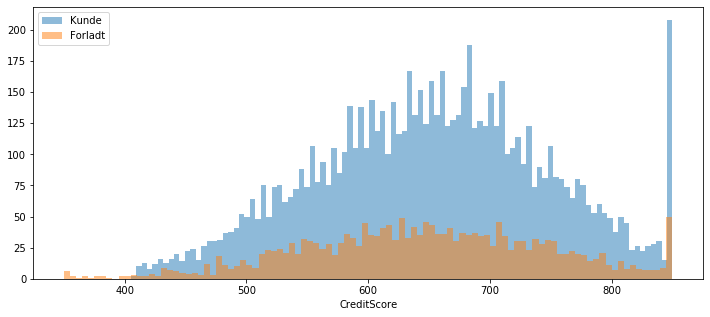

In [16]:
plot_dual_histogram(df_data, 'CreditScore', bins=100)

- Generelt: datasættet indeholder større observationer af personer som forbliver kunder fremfor personer, der forlader banken. Vær opmærksom på ubalanceret data.
- Umiddelbart ser fordelingerne nogenlunde ens ud.
- Der er et peak ved 850. Lader til at der er en stor andel som har den højest kreditscore. 

Hypotese: fordeling for kunder med en kredit score på 850 er anderledes end dem under 850.

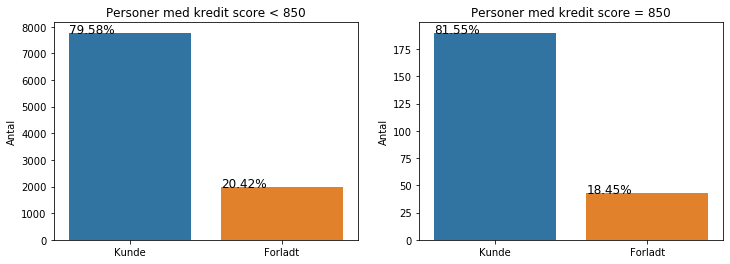

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_target_histogram(df_data[df_data['CreditScore'] < 850], ax[0])
plot_target_histogram(df_data[df_data['CreditScore'] == 850], ax[1])
ax[0].set_title('Personer med kredit score < 850');
ax[1].set_title('Personer med kredit score = 850');

Det lader ikke til at der er den forskel i fordelingerne.

In [18]:
numerical_features.add('CreditScore')

### Alder (Age)

In [19]:
df_data[['Age']].describe().T.style.format("{:,.0f}")

,count,mean,std,min,25%,50%,75%,max
Age,"10,000",39,10,18,32,37,44,92


- Alder fra 18 til 92. Ikke noget mærkeligt.

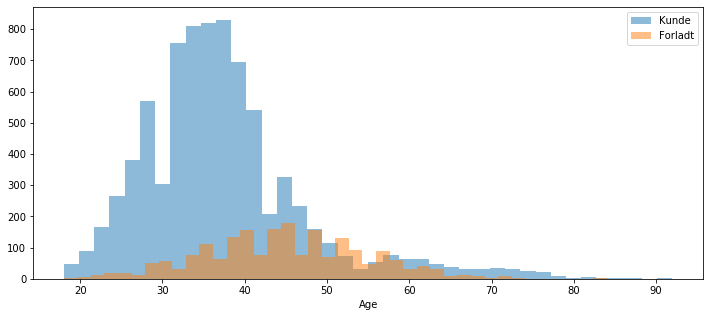

In [20]:
plot_dual_histogram(df_data, 'Age', bins=40)

- Det lader til at der er forskel i aldersfordeling mellem kunder og ikke-kunder. 
- Kan muligvis udnyttes til at inddele kunder i forskellige aldersgruppe så en model har nemmere ved at adskille yngre og ændre kunder fra hinanden.

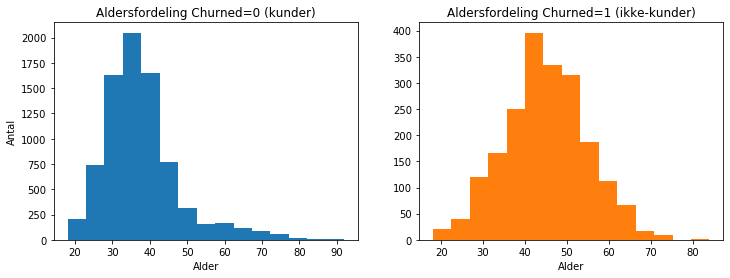

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(df_data[df_data['Churned'] == 0]['Age'], bins=15, color=plot_colors[0]);
ax[1].hist(df_data[df_data['Churned'] == 1]['Age'], bins=15, color=plot_colors[1]);
for i in range(2):
    ax[i].set_xlabel('Alder')
ax[0].set_title('Aldersfordeling Churned=0 (kunder)')
ax[1].set_title('Aldersfordeling Churned=1 (ikke-kunder)')
ax[0].set_ylabel('Antal');

In [22]:
# df_data['AgeGroup'] = pd.cut(df_data['Age'], bins=15, right=False).astype(str)
df_data['AgeGroup'] = pd.cut(df_data['Age'], bins=15, right=False).apply(lambda x: int(x.left))

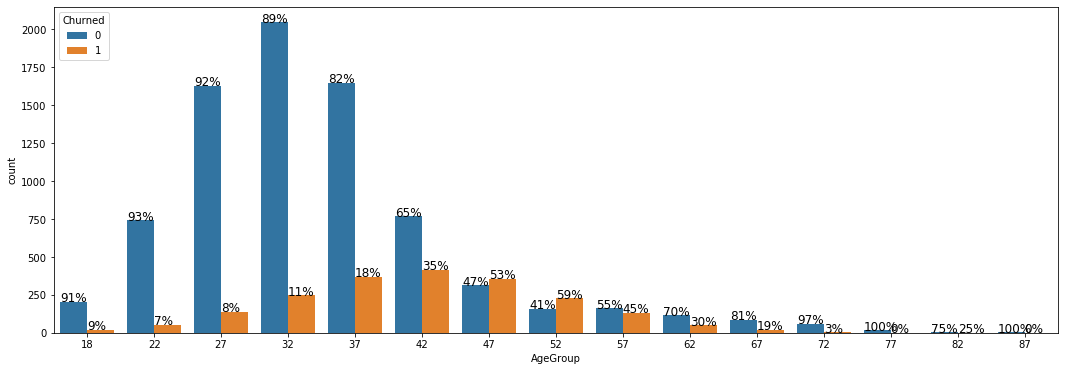

In [23]:
fig, ax = plt.subplots(figsize=(18, 6))
plot_histogram(df_data.sort_values('AgeGroup'), 'AgeGroup', annotate=True, ax=ax)

In [24]:
numerical_features.add('Age')
ordinal_features.add('AgeGroup')

### Tenure

In [25]:
df_data[['Tenure']].describe().T.style.format("{:,.0f}")

,count,mean,std,min,25%,50%,75%,max
Tenure,"10,000",5,3,0,3,5,7,10


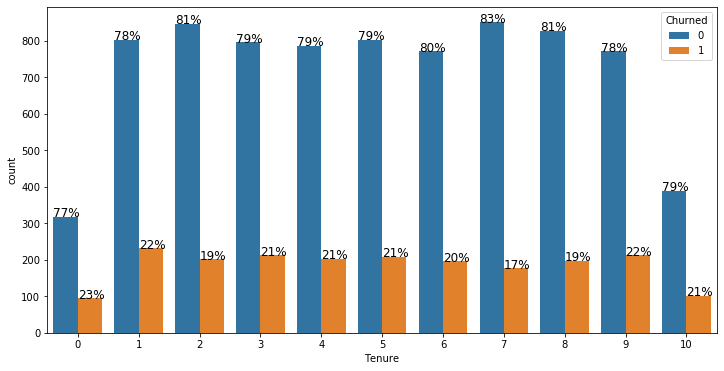

In [26]:
plot_histogram(df_data, 'Tenure', annotate=True)

- Heltalsværdier fra 0 til 10. Ukendt om det er måneder eller år.
- Fordelinger er nogenlunde ens.

In [27]:
numerical_features.add('Tenure')

### Balance

In [28]:
df_data[['Balance']].describe().T.style.format("{:,.0f}")

,count,mean,std,min,25%,50%,75%,max
Balance,"10,000","76,486","62,397",0,0,"97,199","127,644","250,898"


- Antager valuta er i euro. Max værdien €250.898 virker meget højt, men det er vel ikke unormalt.

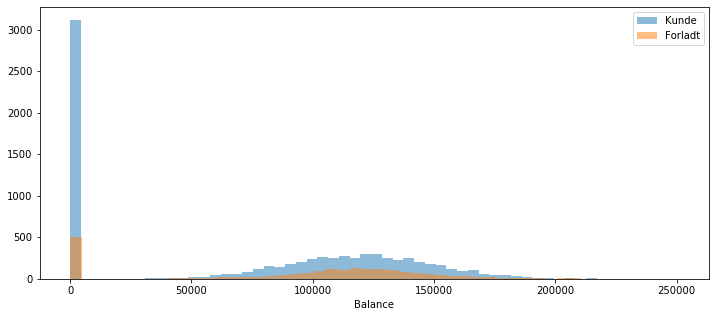

In [29]:
plot_dual_histogram(df_data, 'Balance', bins=50)

- Lidt underligt at kunder som har forladt banken har noget indestående. Antager at det er det beløb som tidligere kunder havde stående før de forlod banken
- Andelen af kunder med formuer som forlader banken er større end dem med 0 i indstående.
- Ide til ny feature: boolean feature om man har penge stående i banken.

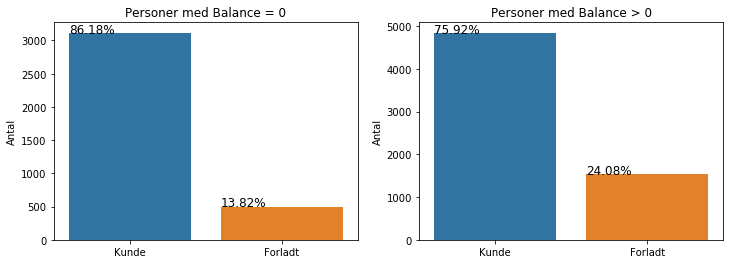

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
threshold_value = 0
plot_target_histogram(df_data[df_data['Balance'] == threshold_value], ax[0])
plot_target_histogram(df_data[df_data['Balance'] > threshold_value], ax[1])
ax[0].set_title('Personer med Balance = {}'.format(threshold_value));
ax[1].set_title('Personer med Balance > {}'.format(threshold_value));

In [31]:
df_data['HasAnyDeposit'] = df_data['Balance'].apply(lambda x: int(x > 0))

In [32]:
numerical_features.add('Balance')
binary_features.add('HasAnyDeposit')

### Løn (Salary)

In [33]:
df_data[['Salary']].describe().T.style.format("{:,.0f}")

,count,mean,std,min,25%,50%,75%,max
Salary,"10,000","100,090","57,510",12,"51,002","100,194","149,388","199,992"


Værdierne virker pæne ud! Lad os kigge på fordelingen.

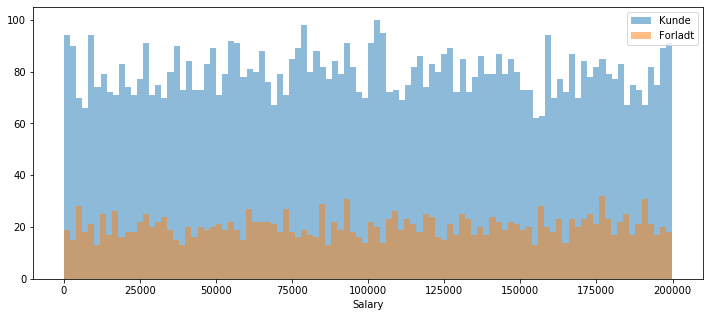

In [34]:
plot_dual_histogram(df_data, 'Salary', bins=100)

Denne feature har en uniform fordeling. Får et indtryk af at værdierne er genereret tilfældigt.

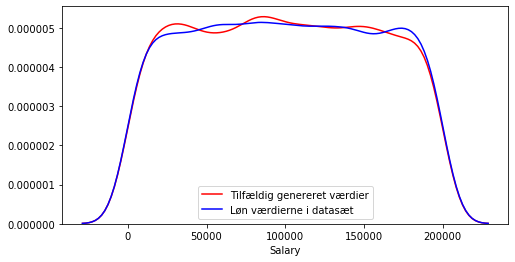

In [35]:
fig, ax = plt.subplots(figsize=(8, 4))
random_salary = np.random.uniform(low=0, high=200000, size=10000)
sns.distplot(random_salary, hist=False, label='Tilfældig genereret værdier', color='red', ax=ax)
sns.distplot(df_data['Salary'], hist=False, label='Løn værdierne i datasæt', color='blue', ax=ax);

Noget tyder på at **Salary** er syntetisk. Måske er data genereret på baggrund af reelle data for at anonymsere det.

In [36]:
numerical_features.add('Salary')

### Antal bankydelser (NumOfProducts)

In [37]:
df_data[['NumOfProducts']].describe().T.style.format("{:,.0f}")

,count,mean,std,min,25%,50%,75%,max
NumOfProducts,"10,000",2,1,1,1,1,2,4


- Antager at dette er antallet af bankydelser som kunden har haft på det tidspunkt data er blevet udtrukket.
- 75% af kunderne har 2 eller 1 bankydelse tilknytter


Lad os kigge på fordelingen.

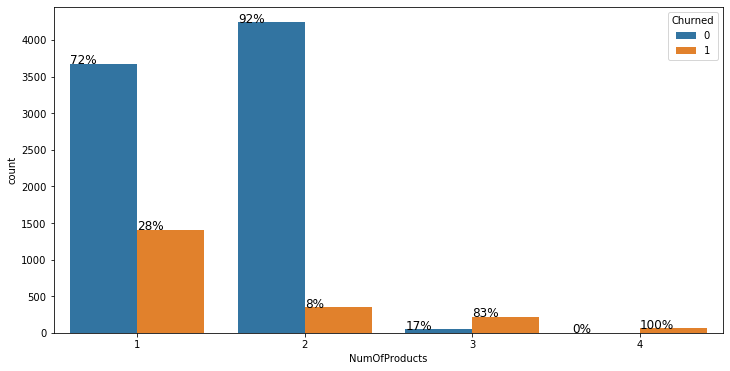

In [38]:
plot_histogram(df_data, 'NumOfProducts')

Observationer:
- Poisson fordeling
- Ingen af de nuværende kunder har 4 produkter!
- Hvis en kunde har 3 bankydelser så er der høj chance for at den kunde forlader butikken.
- Høj signal i denne feature.

In [39]:
# count_features.add('NumOfProducts')
numerical_features.add('NumOfProducts')

### Lokation (Geography)

In [40]:
get_counts(df_data, 'Geography')

,France,Germany,Spain
Geography,"5,014.0","2,509.0","2,477.0"
Proportion,50.1,25.1,24.8


- Halvdelen af personer er fra Frankrig. Ca 25% fra Tyskland og resterende fra Spanien.

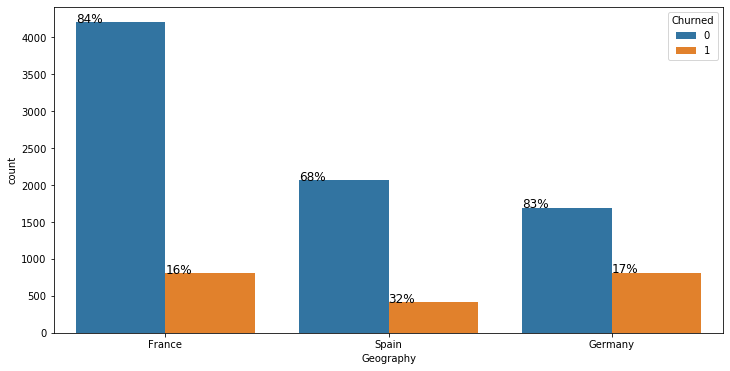

In [41]:
plot_histogram(df_data, 'Geography', annotate=True)

- Andelen af kunder og ikke-kunder er nogenlunde det samme i Frankrig og Tyskland
- I Spanien er der en relativ høj andel af ikke-kunder ifht. kunder.

In [42]:
# One-hot encoding
df_geo_dummies = pd.get_dummies(df_data['Geography'], prefix='IsFrom', prefix_sep='')
df_data = df_data.merge(df_geo_dummies, left_index=True, right_index=True)

In [43]:
nominal_features.add('Geography')
binary_features.update(df_geo_dummies.columns)

### Køn (Gender)

In [44]:
get_counts(df_data, 'Gender')

,Male,Female
Gender,"5,457.0","4,543.0"
Proportion,54.6,45.4


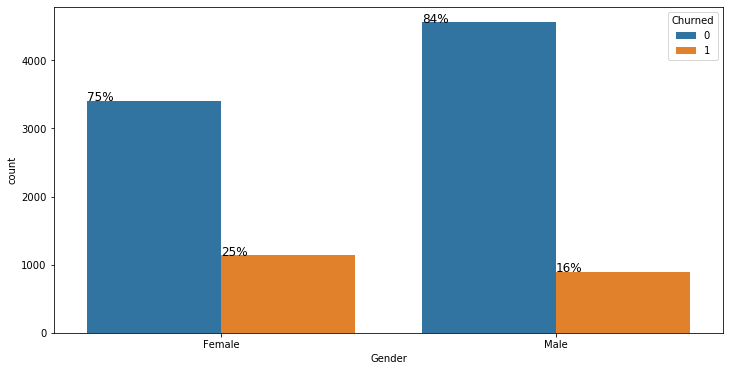

In [45]:
plot_histogram(df_data, 'Gender', annotate=True)

- Ca. 55% mænd og 45% kvinder
- En lidt højere andel af kvindelige kunder forlader banken.

In [46]:
df_data['IsMale'] = df_data['Gender'].apply(lambda x: int(x == 'Male'))

In [47]:
nominal_features.add('Gender')
binary_features.add('IsMale')

### Har kredit kort (HasCreditCard)

In [48]:
get_counts(df_data, 'HasCreditCard')

,1,0
HasCreditCard,"7,055.0","2,945.0"
Proportion,70.5,29.4


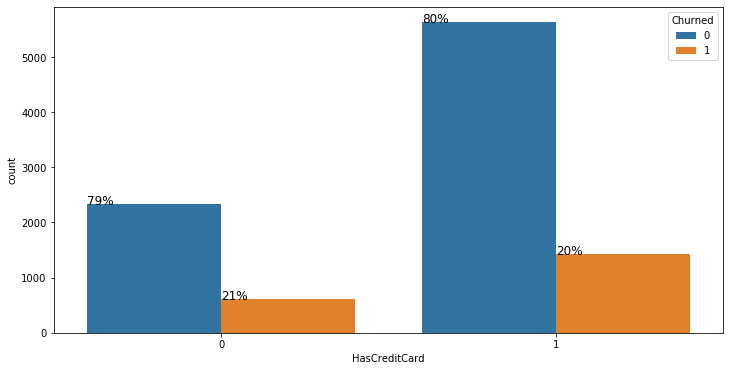

In [49]:
plot_histogram(df_data, 'HasCreditCard', annotate=True)

- Ca. 71% af personerne har (haft) kreditkort
- Nogenlunde samme fordeling i de to klasser

In [50]:
binary_features.add('HasCreditCard')

### Er aktiv (IsActiveMember)

In [51]:
get_counts(df_data, 'IsActiveMember')

,1,0
IsActiveMember,"5,151.0","4,849.0"
Proportion,51.5,48.5


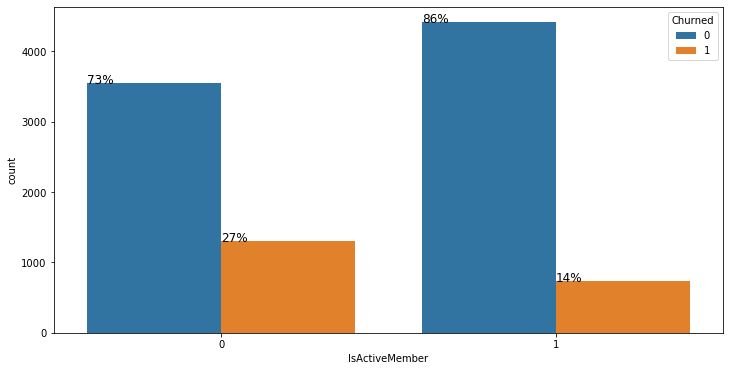

In [52]:
plot_histogram(df_data, 'IsActiveMember', annotate=True)

- Ca. 52% af personerne er aktive (hvad end det betyder)
- Højere andel af ikke-aktive kunder forlader banken

In [53]:
binary_features.add('IsActiveMember')

### Target feature (Churned)

Vi har tidligere set at datasættet er ubalaceret. Lad os kigge på hvor stor er ubalancen.

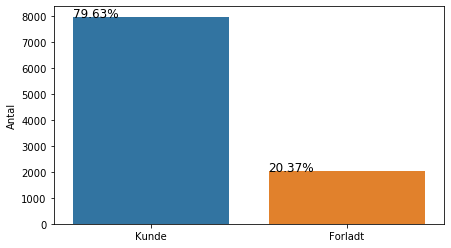

In [54]:
plot_target_histogram(df_data);

Fordelingen er 1:4. Vi kan ikke bruge accuracy. Vi skal bruge F1 score og ROC area under curve.

Der er to udfordringer som vi skal løst:
1. ubalanceret data øger risikoen for at vores model performer dårlig fordi den bliver biased mod den store klasse dvs. minoritetsklassen bliver modeleret mindre godt
2. omkostningen ved at prædiktere forkert på kunder der er ved at forlade banken er højere end en forkert prediktion i den omvendte situation
   - hvis modellen prædikterer at en kunde vil blive mens kunden er på vej ud så er det en større fejl end hvis modellen prædiktere at en kunde er på vej ud men i virkligheden vil kunden slet ikke nogen steder
   - derfor skal modellen ikke lave type fejl

Det er nok mere interessant at studere kunder, der er på vej væk.


### Korrelationer mellem features

Lad os kigge på om vi kan få flere insights ved at kigge på features parvis.

In [55]:
# Backup up ID features and remove them from the working dataframe
df_data_ids = df_data[id_features].copy()
df_data.drop(id_features, axis=1, inplace=True)

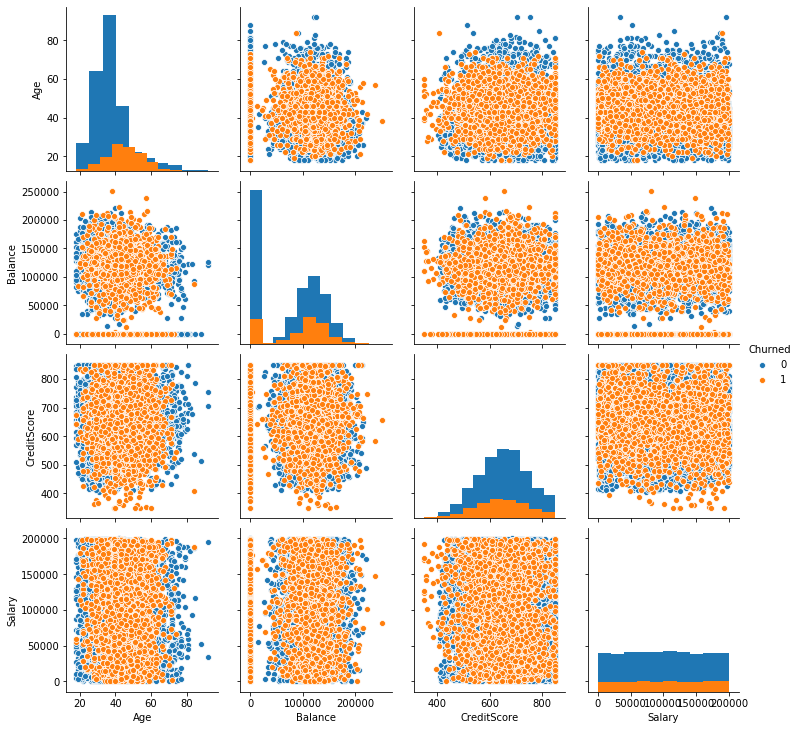

In [56]:
sns.pairplot(df_data, vars=['Age', 'Balance', 'CreditScore', 'Salary'], hue='Churned', diag_kind='hist')

Umiddelbart ingen korrelationer mellem disse features.


Lad os kigge på korrelationer mellem alle features.

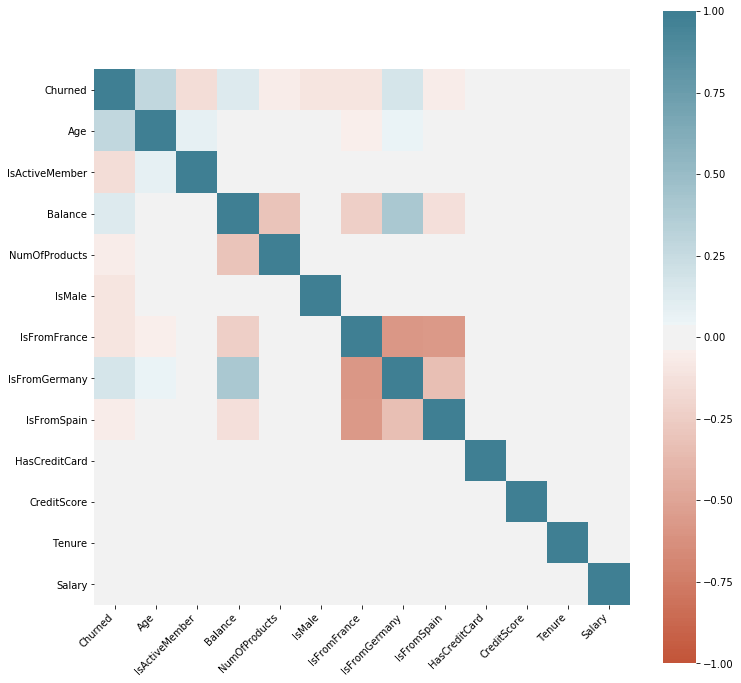

In [57]:
columns = [
    'Churned', 'Age', 'IsActiveMember', 'Balance', 'NumOfProducts', 'IsMale', 'IsFromFrance', 
    'IsFromGermany', 'IsFromSpain', 'HasCreditCard', 'CreditScore',  'Tenure', 'Salary',
]
plot_corr(df_data[columns])

- CreditScore, Salary, Tenure og HasCreditCard har ingen correlation med nogen af de andre features

## Klargøring af data

### Train/test split

In [58]:
input_features = numerical_features.union(ordinal_features).union(binary_features)
X = df_data[input_features]
y = df_data[target_feature]

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [60]:
df_train = pd.merge(X_train, y_train, left_index=True, right_index=True)

In [61]:
df_train.to_csv('train_data.csv')

## Feature selection

Målet er at finde ud af hvilke features der har høj signal vs. støjende features.
Der er flere tilgange til feature selection (filtering and wrapping).

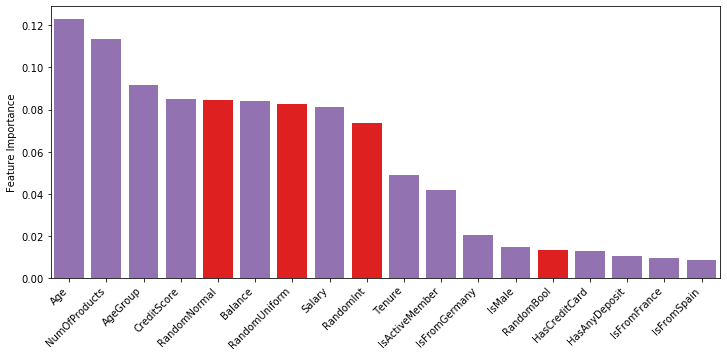

In [62]:
X = X_train.copy()
y = y_train.copy()
X['RandomUniform'] = np.random.random(len(X))
X['RandomNormal'] = np.random.random(size=len(X))
X['RandomInt'] = np.random.randint(low=2, high=100, size=len(X))
X['RandomBool'] = np.random.randint(low=0, high=2, size=len(X))

plot_random_forest_feature_importance(X, y)

## Model udvælgelse

In [63]:
import json
import importlib
from pathlib import Path

from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import make_scorer, cohen_kappa_score, matthews_corrcoef, roc_curve, roc_auc_score
import skopt

from skopt import BayesSearchCV

from sklearn.svm import SVC

cohen_kappa_scorer = make_scorer(cohen_kappa_score)



In [64]:
def calc_cv_avg_score(model, x, y, scoring = 'f1', n_folds: int = 5, random_state: int = 42):
    cv_splitter = StratifiedKFold(n_splits=n_folds, random_state=random_state, shuffle=True)
    scores = cross_val_score(model, x, y, cv=cv_splitter, scoring=scoring, verbose=0, n_jobs=-1)
    return scores

def fetch_best_params(algorithm_name: str):
    hyperparam_path = Path('hyperparams') / '{}.json'.format(algorithm_name)
    with open(hyperparam_path, 'r') as file:
        hyperparams = json.load(file)['best_params']
    return hyperparams
    
def prepare_classifier(algorithm_name: str):
    algo = importlib.import_module('algorithms.{}'.format(algorithm_name))
    classifier = algo.get_classifier()
    best_hyperparams = fetch_best_params(algorithm_name)
    classifier.set_params(**best_hyperparams)
    return classifier

def get_final_cv_avg_score(algorithm_name: str, X, y, scoring='f1', n_jobs=-1, n_folds=5, random_state=42, ):
    classifier = prepare_classifier(algorithm_name)
    cv_splitter = StratifiedKFold(n_splits=n_folds, random_state=random_state, shuffle=True)
    final_scores = cross_val_score(
        classifier, X, y, n_jobs=n_jobs, cv=cv_splitter, scoring=scoring, verbose=0
    )
    return final_scores.mean(), classifier

<div style="text-align:left">
<img src="https://i.imgur.com/m0dkysg.png" style="width: 600px;" title="Confusion matrix" />
</div>

Kilde: https://manisha-sirsat.blogspot.com/2019/04/confusion-matrix.html

- Vi kan ikke bruge accuracy da data er ubalaceret data
- F1 score er en harmonisk gennemsnit af Precision og Sensitivity (Recall) så det er bedre i det her tilfælde

### Baseline: majority klasse classifier

In [65]:
mc_model = DummyClassifier(strategy='most_frequent')
mc_cv_scores = calc_cv_avg_score(mc_model, X_train, y_train, scoring='f1')

In [66]:
mc_cv_scores.mean()

0.0

### Baseline: random classifier

In [67]:
random_model = DummyClassifier(strategy='stratified', random_state=1)
random_cv_scores = calc_cv_avg_score(random_model, X_train, y_train, scoring='f1')

In [68]:
random_cv_scores.mean()

0.21949025487256374

### Logistisk regression

In [69]:
lr_cv_scores, lr_model = get_final_cv_avg_score('lr', X_train, y_train, scoring='f1')

In [70]:
lr_cv_scores.mean()

0.4932322252728271

### SVM

In [71]:
svm_cv_scores, svm_model = get_final_cv_avg_score('svm', X_train, y_train, scoring='f1')

In [72]:
svm_cv_scores.mean()

0.5968363892875733

### Random Forest

In [73]:
rf_cv_scores, rf_model = get_final_cv_avg_score('random_forest', X_train, y_train, scoring='f1')

In [74]:
rf_cv_scores.mean()

0.6070432171789854

### XGBoost

In [75]:
xgb_cv_scores, xgb_model = get_final_cv_avg_score('xgboost', X_train, y_train, scoring='f1')

In [76]:
xgb_cv_scores.mean()

0.5854151970699006

### Sammenligning

In [77]:
import scikitplot as skplt

def get_roc_curve_scores(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_val)
    fpr, tpr, threshold = roc_curve(y_val, y_pred_proba[::,1])
    score = roc_auc_score(y_val, y_pred_proba[::,1])
    return fpr, tpr, score

def plot_roc(X, y, models):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    fig, ax = plt.subplots(figsize=(12, 10))
    for name, model in models:
        print('Behandler {}...'.format(name))
        fpr, tpr, score = get_roc_curve_scores(model, X_train, X_val, y_train, y_val)
        sns.lineplot(fpr, tpr, label='{} AUC: {:.4f}'.format(name, score), ax=ax)
    
    ax.legend()
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    return ax

Behandler Majority Classifier...
Behandler Random Classifier...
Behandler Logistisk Regression...
Behandler SVM...
Behandler Random Forest...
Behandler XGBoost...


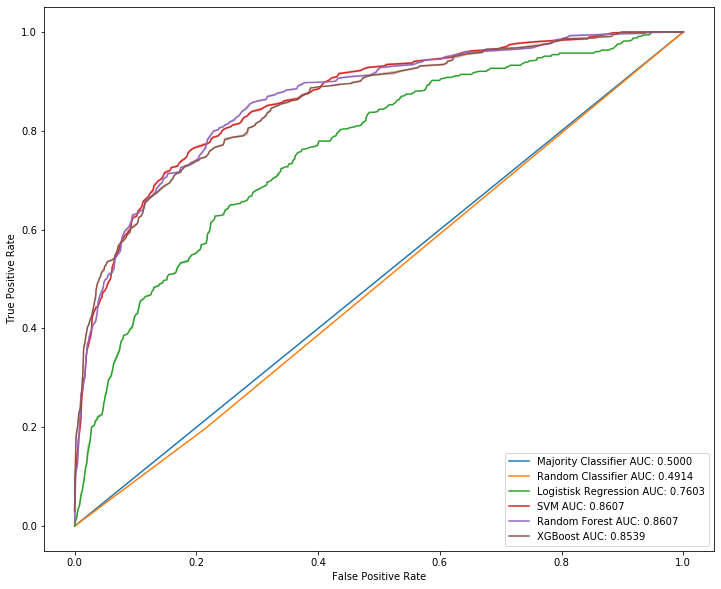

In [78]:
plot_roc(X_train, y_train, [
    ('Majority Classifier', mc_model),
    ('Random Classifier', random_model),
    ('Logistisk Regression', lr_model),
    ('SVM', svm_model),
    ('Random Forest', rf_model),
    ('XGBoost', xgb_model),
])

## Performance på testsæt

In [79]:
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [80]:
print(classification_report(np.array(y_test), y_pred))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88      1593
           1       0.54      0.73      0.62       407

    accuracy                           0.82      2000
   macro avg       0.73      0.79      0.75      2000
weighted avg       0.85      0.82      0.83      2000



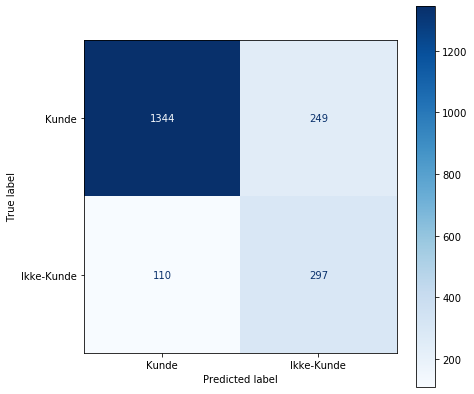

In [81]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(
    rf_model, X_test, y_test, display_labels=['Kunde', 'Ikke-Kunde'],
    cmap=plt.cm.Blues, values_format='.0f', ax=ax
)